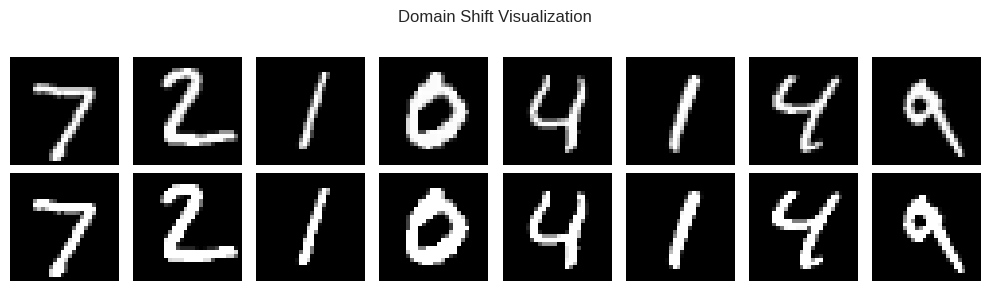


INITIALIZING SIMPLE TRANSFORMER

Training baseline Transformer...
Epoch 1/30: train_loss=2.3711 test_acc=0.2391
Epoch 2/30: train_loss=2.2765 test_acc=0.2544
Epoch 4/30: train_loss=2.1689 test_acc=0.3212
Epoch 6/30: train_loss=1.9669 test_acc=0.3289
Epoch 8/30: train_loss=1.7939 test_acc=0.4123
Epoch 10/30: train_loss=1.6465 test_acc=0.4204
Epoch 12/30: train_loss=1.6508 test_acc=0.4275
Epoch 14/30: train_loss=1.6325 test_acc=0.4762
Epoch 16/30: train_loss=1.5715 test_acc=0.4758
Epoch 18/30: train_loss=1.5015 test_acc=0.5208
Epoch 20/30: train_loss=1.4543 test_acc=0.5243
Epoch 22/30: train_loss=1.4561 test_acc=0.5259
Epoch 24/30: train_loss=1.3708 test_acc=0.5455
Epoch 26/30: train_loss=1.4344 test_acc=0.5665
Epoch 28/30: train_loss=1.3646 test_acc=0.5777
Epoch 30/30: train_loss=1.3994 test_acc=0.5867

Baseline accuracy (original): 0.5867
Baseline accuracy (shifted):  0.6015
Performance drop: -0.0148


SELECTIVE ADAPTATION (FC LAYER ONLY)
Adapt Epoch 1/5: loss=1.2363 acc=0.6014
Adapt 

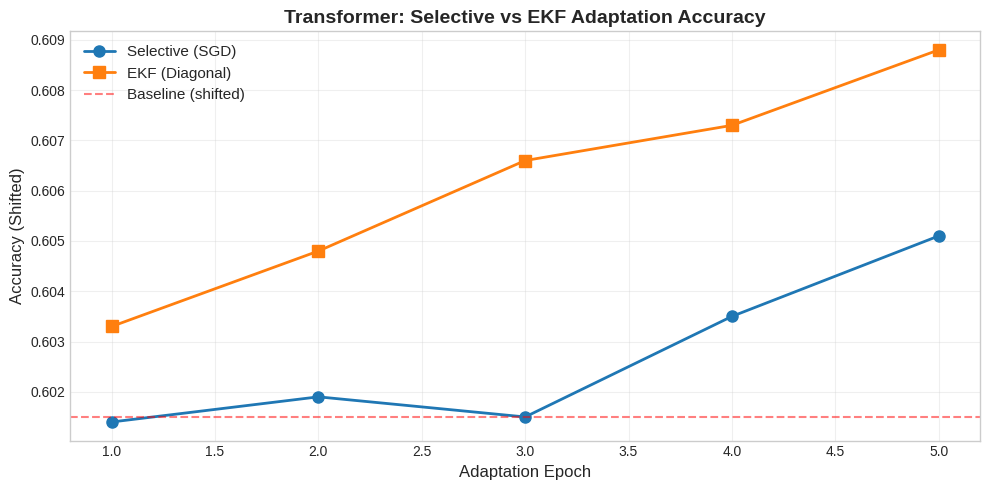

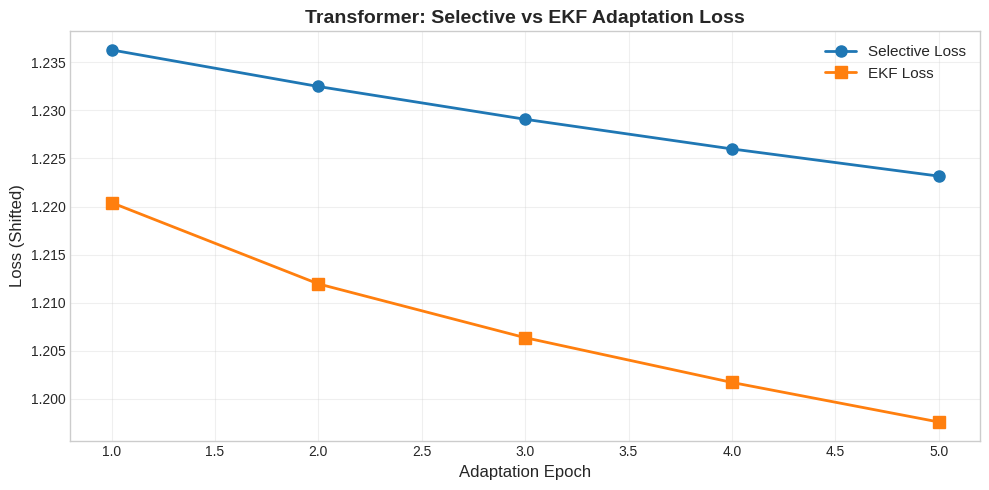


Parameter L2 change (Baseline → Selective): 0.132487
Parameter L2 change (Baseline → EKF):       0.303534



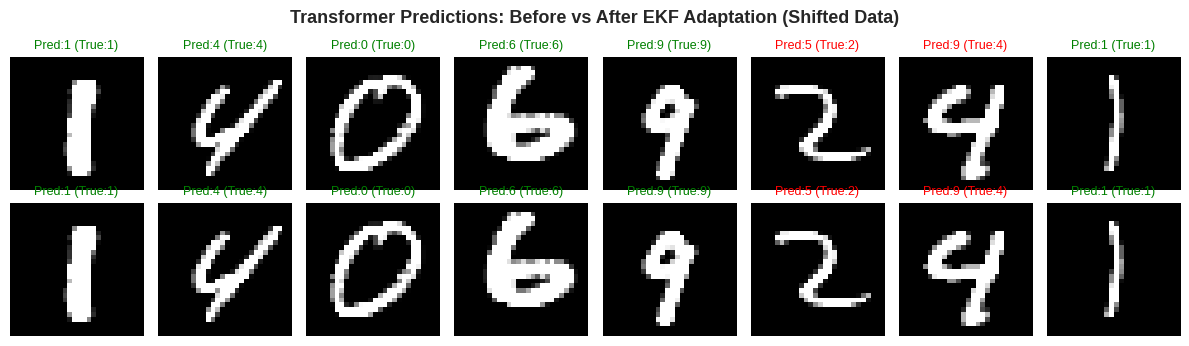


SUMMARY
Architecture: Simple Transformer (patch_size=7, embed_dim=64, 2 blocks)
Baseline accuracy (original): 0.5867
Baseline accuracy (shifted):  0.6015
Selective final accuracy:     0.6051
EKF final accuracy:           0.6088



In [ ]:
# =====================================
# 1. Setup and Data Preparation
# =====================================
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from flax import nnx
from tensorflow.keras.datasets import mnist
import copy

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

# Create domain shift: contrast and brightness
X_test_shifted = np.clip(((X_test - 0.5) * 1.8 + 0.5) + 0.4, 0, 1)
y_test_shifted = y_test

# Visualize domain shift
fig, axes = plt.subplots(2, 8, figsize=(10, 3))
for i in range(8):
    axes[0, i].imshow(X_test[i], cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(X_test_shifted[i], cmap="gray")
    axes[1, i].axis("off")
axes[0, 0].set_ylabel("Original", rotation=0, labelpad=40)
axes[1, 0].set_ylabel("Shifted", rotation=0, labelpad=40)
plt.suptitle("Domain Shift Visualization")
plt.tight_layout()
plt.show()

# =====================================
# 2. Simple Transformer Components
# =====================================

class SimpleAttention(nnx.Module):
    """Single-head self-attention"""
    def __init__(self, embed_dim, *, rngs: nnx.Rngs):
        self.embed_dim = embed_dim
        # Q, K, V projections
        self.query = nnx.Linear(embed_dim, embed_dim, rngs=rngs)
        self.key = nnx.Linear(embed_dim, embed_dim, rngs=rngs)
        self.value = nnx.Linear(embed_dim, embed_dim, rngs=rngs)

    def __call__(self, x):
        # x: (batch, seq_len, embed_dim)
        Q = self.query(x)  # (batch, seq_len, embed_dim)
        K = self.key(x)
        V = self.value(x)

        # Attention scores
        scores = jnp.matmul(Q, K.transpose(0, 2, 1)) / jnp.sqrt(self.embed_dim)
        attn_weights = jax.nn.softmax(scores, axis=-1)  # (batch, seq_len, seq_len)

        # Apply attention to values
        output = jnp.matmul(attn_weights, V)  # (batch, seq_len, embed_dim)
        return output


class TransformerBlock(nnx.Module):
    """Single transformer block with attention + FFN"""
    def __init__(self, embed_dim, ffn_dim, *, rngs: nnx.Rngs):
        # Self-attention
        self.attention = SimpleAttention(embed_dim, rngs=rngs)
        self.norm1 = nnx.LayerNorm(embed_dim, rngs=rngs)

        # Feed-forward network
        self.ffn1 = nnx.Linear(embed_dim, ffn_dim, rngs=rngs)
        self.ffn2 = nnx.Linear(ffn_dim, embed_dim, rngs=rngs)
        self.norm2 = nnx.LayerNorm(embed_dim, rngs=rngs)

    def __call__(self, x):
        # Attention block with residual
        attn_out = self.attention(x)
        x = self.norm1(x + attn_out)

        # FFN block with residual
        ffn_out = self.ffn2(jax.nn.relu(self.ffn1(x)))
        x = self.norm2(x + ffn_out)

        return x


class SimpleTransformer(nnx.Module):
    """Simple Transformer for MNIST classification"""
    def __init__(self, patch_size, embed_dim, num_blocks, num_classes, *, rngs: nnx.Rngs):
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Patch embedding: flatten patches and project
        self.patch_embed = nnx.Linear(patch_size * patch_size, embed_dim, rngs=rngs)

        # Transformer blocks
        self.blocks = [TransformerBlock(embed_dim, embed_dim * 2, rngs=rngs)
                      for _ in range(num_blocks)]

        # Classification head
        self.fc = nnx.Linear(embed_dim, num_classes, rngs=rngs)

    def __call__(self, x):
        # x: (batch, 28, 28)
        batch_size = x.shape[0]

        # Create patches: (batch, 28, 28) -> (batch, num_patches, patch_size^2)
        # For 28x28 with patch_size=7: 4x4 = 16 patches
        patches = jnp.reshape(x, (batch_size, 28 // self.patch_size, self.patch_size,
                                  28 // self.patch_size, self.patch_size))
        patches = jnp.transpose(patches, (0, 1, 3, 2, 4))
        patches = jnp.reshape(patches, (batch_size, -1, self.patch_size * self.patch_size))

        # Embed patches
        x = self.patch_embed(patches)  # (batch, num_patches, embed_dim)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Global average pooling over patches
        x = jnp.mean(x, axis=1)  # (batch, embed_dim)

        # Classification
        return self.fc(x)


# =====================================
# 3. Loss, Accuracy, and Utility
# =====================================

def cross_entropy(logits, labels):
    y = jax.nn.one_hot(labels, 10)
    return -jnp.mean(jnp.sum(y * jax.nn.log_softmax(logits), axis=-1))


def accuracy(logits, labels):
    return jnp.mean(jnp.argmax(logits, -1) == labels)


def eval_batch(model, x, y):
    logits = model(x)
    return cross_entropy(logits, y), accuracy(logits, y)


# =====================================
# 4. Baseline Training
# =====================================

print("\n" + "="*50)
print("INITIALIZING SIMPLE TRANSFORMER")
print("="*50)

rngs = nnx.Rngs(0)
model = SimpleTransformer(
    patch_size=7,      # 7x7 patches -> 4x4 = 16 patches per image
    embed_dim=64,      # Embedding dimension
    num_blocks=2,      # 2 transformer blocks
    num_classes=10,
    rngs=rngs
)

optimizer = nnx.Optimizer(model, optax.adam(2e-3))

epochs = 30
batch_size = 512
train_losses, test_accs = [], []

print("\nTraining baseline Transformer...")
for ep in range(epochs):
    # Random mini-batch sampling
    idx = np.random.choice(len(X_train), batch_size, replace=False)
    Xb, yb = X_train[idx], y_train[idx]

    def loss_fn(model):
        logits = model(Xb)
        loss = cross_entropy(logits, yb)
        return loss, logits

    (loss_value, _), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model)
    optimizer.update(grads)

    # Evaluate every 2 epochs
    if (ep + 1) % 2 == 0 or ep == 0:
        l, a = eval_batch(model, X_test, y_test)
        train_losses.append(float(loss_value))
        test_accs.append(float(a))
        print(f"Epoch {ep+1}/{epochs}: train_loss={float(loss_value):.4f} test_acc={float(a):.4f}")

# Evaluate on shifted data
baseline_model = copy.deepcopy(model)
l_shift, a_shift = eval_batch(model, X_test_shifted, y_test_shifted)
print(f"\n{'='*50}")
print(f"Baseline accuracy (original): {test_accs[-1]:.4f}")
print(f"Baseline accuracy (shifted):  {a_shift:.4f}")
print(f"Performance drop: {(test_accs[-1] - a_shift):.4f}")
print(f"{'='*50}\n")

# =====================================
# 5. Selective Adaptation (Head only)
# =====================================

print("\n" + "="*50)
print("SELECTIVE ADAPTATION (FC LAYER ONLY)")
print("="*50)

selective_model = copy.deepcopy(baseline_model)
sel_opt = nnx.Optimizer(selective_model.fc, optax.adam(1e-3))
sel_losses, sel_accs = [], []
num_adapt_epochs = 5

for ep in range(num_adapt_epochs):
    Xb, yb = X_test_shifted, y_test_shifted

    def loss_fn(fc):
        # Forward through transformer blocks (frozen)
        batch_size = Xb.shape[0]
        patches = jnp.reshape(Xb, (batch_size, 28 // selective_model.patch_size,
                                   selective_model.patch_size,
                                   28 // selective_model.patch_size,
                                   selective_model.patch_size))
        patches = jnp.transpose(patches, (0, 1, 3, 2, 4))
        patches = jnp.reshape(patches, (batch_size, -1,
                                       selective_model.patch_size * selective_model.patch_size))

        x = selective_model.patch_embed(patches)
        for block in selective_model.blocks:
            x = block(x)
        x = jnp.mean(x, axis=1)

        # Stop gradients here
        x = jax.lax.stop_gradient(x)

        # Only train classification head
        logits = fc(x)
        loss = cross_entropy(logits, yb)
        return loss, logits

    (loss_value, _), grads = nnx.value_and_grad(loss_fn, has_aux=True)(selective_model.fc)
    sel_opt.update(grads)

    l, a = eval_batch(selective_model, X_test_shifted, y_test_shifted)
    sel_losses.append(float(l))
    sel_accs.append(float(a))
    print(f"Adapt Epoch {ep+1}/{num_adapt_epochs}: loss={float(l):.4f} acc={float(a):.4f}")

print(f"\nSelective adaptation final accuracy: {sel_accs[-1]:.4f}")
print(f"Improvement: {(sel_accs[-1] - a_shift):.4f}")

# =====================================
# 6. EKF Adaptation (Diagonal Covariance)
# =====================================

print("\n" + "="*50)
print("EKF-BASED ADAPTATION (FC LAYER)")
print("="*50)

ekf_model = copy.deepcopy(baseline_model)
fc = ekf_model.fc
W, b = fc.kernel.value, fc.bias.value

# EKF parameters
P = jnp.ones_like(W) * 0.1   # Parameter uncertainty
Q = jnp.ones_like(W) * 0.01  # Process noise
R = 0.05                      # Measurement noise

ekf_accs, ekf_losses = [], []

for ep in range(num_adapt_epochs):
    # Compute features (frozen transformer backbone)
    batch_size = X_test_shifted.shape[0]
    patches = jnp.reshape(X_test_shifted, (batch_size, 28 // ekf_model.patch_size,
                                           ekf_model.patch_size,
                                           28 // ekf_model.patch_size,
                                           ekf_model.patch_size))
    patches = jnp.transpose(patches, (0, 1, 3, 2, 4))
    patches = jnp.reshape(patches, (batch_size, -1,
                                   ekf_model.patch_size * ekf_model.patch_size))

    features = ekf_model.patch_embed(patches)
    for block in ekf_model.blocks:
        features = block(features)
    features = jnp.mean(features, axis=1)  # (batch, embed_dim)

    # Compute predictions
    logits = ekf_model.fc(features)

    # Prediction error
    y_pred = jax.nn.softmax(logits)
    y_true = jax.nn.one_hot(y_test_shifted, 10)
    err = y_true - y_pred  # (batch, 10)

    # EKF-style update
    grad_like = jnp.mean(err[..., None] * features[:, None, :], axis=0)  # (10, embed_dim)
    K = P / (P + R)  # Kalman gain
    W = W + K * grad_like.T  # Update weights
    P = (1 - K) * P + Q  # Update uncertainty
    fc.kernel.value = W

    # Evaluate
    l, a = eval_batch(ekf_model, X_test_shifted, y_test_shifted)
    ekf_losses.append(float(l))
    ekf_accs.append(float(a))
    print(f"EKF Epoch {ep+1}/{num_adapt_epochs}: loss={float(l):.4f} acc={float(a):.4f}")

print(f"\nEKF adaptation final accuracy: {ekf_accs[-1]:.4f}")
print(f"Improvement: {(ekf_accs[-1] - a_shift):.4f}")

# =====================================
# 7. Visualizations
# =====================================

epochs_adapt = np.arange(1, num_adapt_epochs + 1)

# Accuracy comparison
plt.figure(figsize=(10, 5))
plt.plot(epochs_adapt, sel_accs, 'o-', linewidth=2, markersize=8, label="Selective (SGD)")
plt.plot(epochs_adapt, ekf_accs, 's-', linewidth=2, markersize=8, label="EKF (Diagonal)")
plt.axhline(y=a_shift, color='r', linestyle='--', alpha=0.5, label='Baseline (shifted)')
plt.xlabel("Adaptation Epoch", fontsize=12)
plt.ylabel("Accuracy (Shifted)", fontsize=12)
plt.title("Transformer: Selective vs EKF Adaptation Accuracy", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Loss comparison
plt.figure(figsize=(10, 5))
plt.plot(epochs_adapt, sel_losses, 'o-', linewidth=2, markersize=8, label="Selective Loss")
plt.plot(epochs_adapt, ekf_losses, 's-', linewidth=2, markersize=8, label="EKF Loss")
plt.xlabel("Adaptation Epoch", fontsize=12)
plt.ylabel("Loss (Shifted)", fontsize=12)
plt.title("Transformer: Selective vs EKF Adaptation Loss", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Parameter change magnitude
def l2_diff(m1, m2):
    def flat_params(m):
        return jax.tree_util.tree_flatten(nnx.state(m))[0]
    p1, p2 = flat_params(m1), flat_params(m2)
    return float(sum(jnp.linalg.norm(a - b) for a, b in zip(p1, p2)))

print(f"\n{'='*50}")
print(f"Parameter L2 change (Baseline → Selective): {l2_diff(baseline_model, selective_model):.6f}")
print(f"Parameter L2 change (Baseline → EKF):       {l2_diff(baseline_model, ekf_model):.6f}")
print(f"{'='*50}\n")

# =====================================
# 8. Prediction Visualization
# =====================================

def show_predictions(model_before, model_after, X, y, title):
    idx = np.random.choice(len(X), 8, replace=False)
    Xs, ys = X[idx], y[idx]

    pred_before = jnp.argmax(model_before(Xs), axis=-1)
    pred_after = jnp.argmax(model_after(Xs), axis=-1)

    fig, axes = plt.subplots(2, 8, figsize=(12, 3.5))
    for i in range(8):
        # Before adaptation
        axes[0, i].imshow(Xs[i], cmap="gray")
        color = 'green' if pred_before[i] == ys[i] else 'red'
        axes[0, i].set_title(f"Pred:{pred_before[i]} (True:{ys[i]})",
                            fontsize=9, color=color)
        axes[0, i].axis("off")

        # After adaptation
        axes[1, i].imshow(Xs[i], cmap="gray")
        color = 'green' if pred_after[i] == ys[i] else 'red'
        axes[1, i].set_title(f"Pred:{pred_after[i]} (True:{ys[i]})",
                            fontsize=9, color=color)
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("Before", rotation=0, labelpad=35, fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel("After", rotation=0, labelpad=35, fontsize=11, fontweight='bold')
    plt.suptitle(title, fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_predictions(baseline_model, ekf_model, X_test_shifted, y_test_shifted,
                "Transformer Predictions: Before vs After EKF Adaptation (Shifted Data)")

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Architecture: Simple Transformer (patch_size=7, embed_dim=64, 2 blocks)")
print(f"Baseline accuracy (original): {test_accs[-1]:.4f}")
print(f"Baseline accuracy (shifted):  {a_shift:.4f}")
print(f"Selective final accuracy:     {sel_accs[-1]:.4f}")
print(f"EKF final accuracy:           {ekf_accs[-1]:.4f}")
print(f"{'='*50}\n")